## Baseflow Separation like HYSEP...but with pandas

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-streamgage/blob/main/Streamgage-06--Baseflow-Separation-Part-1.ipynb)

## Setup and imports

In [1]:
# colab uses python 3.7.15 currently and has no zoneinfo
# from zoneinfo import ZoneInfo

from datetime import datetime
import pytz
from math import ceil, floor,fmod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    path = 'https://github.com/mrahnis/nb-streamgage/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [3]:
favorites = {'01576516':'east branch',
         '015765185':'west branch',
         '015765195':'mainstem',
         '01576521':'mainstem-historical'}

gage = '015765195'
freq = 'daily' # daily or instantaneous

#enddate = datetime(2012, 12, 31, 0, 0, tzinfo=ZoneInfo("US/Eastern"))
#startdate = datetime(2012, 1, 1, 0, 0, tzinfo=ZoneInfo("US/Eastern"))
enddate = datetime(2012, 12, 31, 0, 0, tzinfo=pytz.timezone('US/Eastern'))
startdate = datetime(2012, 1, 1, 0, 0, tzinfo=pytz.timezone('US/Eastern'))

for key in favorites:
    print('https://waterdata.usgs.gov/monitoring-location/{}/'.format(key))

https://waterdata.usgs.gov/monitoring-location/01576516/
https://waterdata.usgs.gov/monitoring-location/015765185/
https://waterdata.usgs.gov/monitoring-location/015765195/
https://waterdata.usgs.gov/monitoring-location/01576521/


## Load data

In [4]:
# load data
df_all = pd.read_parquet('{}/data/nwis_{}_{}_all.parquet{}'.format(path, gage, freq, params))

df = df_all[startdate:enddate].copy()
col = '00060_Mean'

## Sliding interval baseflow separation

In [5]:
# Calculate window size based on the USGS HYSEP documentation: http://water.usgs.gov/software/HYSEP/
# the drainage area in square miles
a = 1.68

# floating point HYSEP recession window
n = pow(a, 0.2)

if freq == 'instantaneous': window = 2*n*24*60/15 # Real-time window in 15 minute periods
elif freq == 'daily': window = 2*n                # HYSEP window in days
else: print('error')

if window < 3: window = 3.
elif fmod(window, 2) >= 1: window = floor(window)
else: window = ceil(window)

print('frequency: {0}'.format(freq))
print('window: {0}'.format(window))

frequency: daily
window: 3.0


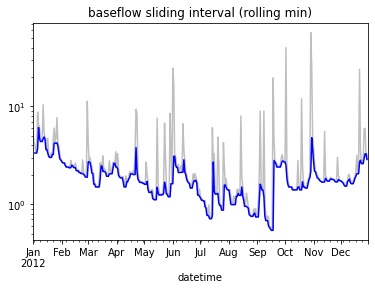

In [6]:
# Sliding Interval: this is a rolling_min shifted one-half window
df['roll'] = df[col].shift(int(-(window-1)/2)).rolling(int(window)).min()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
df[col].plot(ax=ax1, color='gray', alpha=0.5)
df['roll'].plot(ax=ax1, color='blue')
ax1.set_title('baseflow sliding interval (rolling min)')
plt.show()

## Local minimum baseflow separation

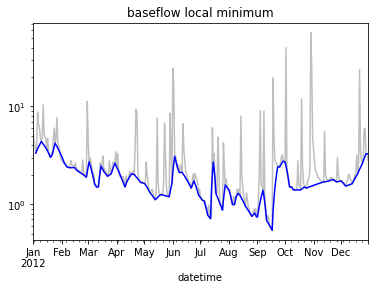

In [7]:
# Local Minimum: select the times where value is equal to the rolling_min, then fill by interpolation
df['local'] = df[col].where(df[col] == df['roll']).interpolate()

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.set_yscale('log')
df[col].plot(ax=ax2, color='gray', alpha=0.5)
df['local'].plot(ax=ax2, color='blue')
ax2.set_title('baseflow local minimum')
plt.show()

## Fixed interval baseflow separation

C:\Users\miker\AppData\Local\Temp\ipykernel_10484\3437476378.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[int(window*i):int(window*(i+1)), 'fixed'] = df[col].iloc[int(window*i):int(window*(i+1))].min()


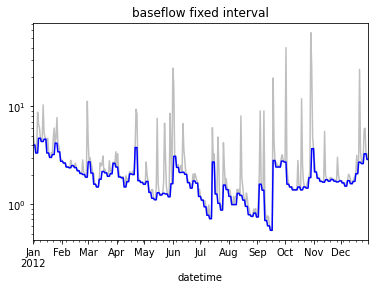

In [8]:
# Fixed Interval Method: get lowest in a group at a given interval, fill the interval with that value
df['fixed'] = 0.
for i in range(int(ceil(len(df)/window))):
    df.loc[int(window*i):int(window*(i+1)), 'fixed'] = df[col].iloc[int(window*i):int(window*(i+1))].min()

fig = plt.figure()
ax3 = fig.add_subplot(111)
ax3.set_yscale('log')
df[col].plot(ax=ax3, color='gray', alpha=0.5)
df['fixed'].plot(ax=ax3, color='blue')
ax3.set_title('baseflow fixed interval')
plt.show()

## Compare results

In [9]:
df[['00060_Mean','roll','local','fixed']]

,00060_Mean,roll,local,fixed
datetime,,,,
2012-01-01 00:00:00-05:00,5.67,NaN,NaN,4.03
2012-01-02 00:00:00-05:00,4.35,NaN,NaN,4.03
2012-01-03 00:00:00-05:00,4.03,3.34,NaN,4.03
2012-01-04 00:00:00-05:00,3.34,3.34,3.340000,3.34
2012-01-05 00:00:00-05:00,3.72,3.34,3.513333,3.34
...,...,...,...,...
2012-12-26 00:00:00-05:00,5.86,2.96,2.940000,3.28
2012-12-27 00:00:00-05:00,5.99,3.28,3.110000,3.28
2012-12-28 00:00:00-05:00,3.28,3.28,3.280000,3.28


## References:

A recent evaluation of baseflow separation calculations:
https://pubs.er.usgs.gov/publication/sir20175034

HYSEP documentation:
https://water.usgs.gov/software/HYSEP/code/doc/hysep.pdf


